vintage.ts already downloaded.


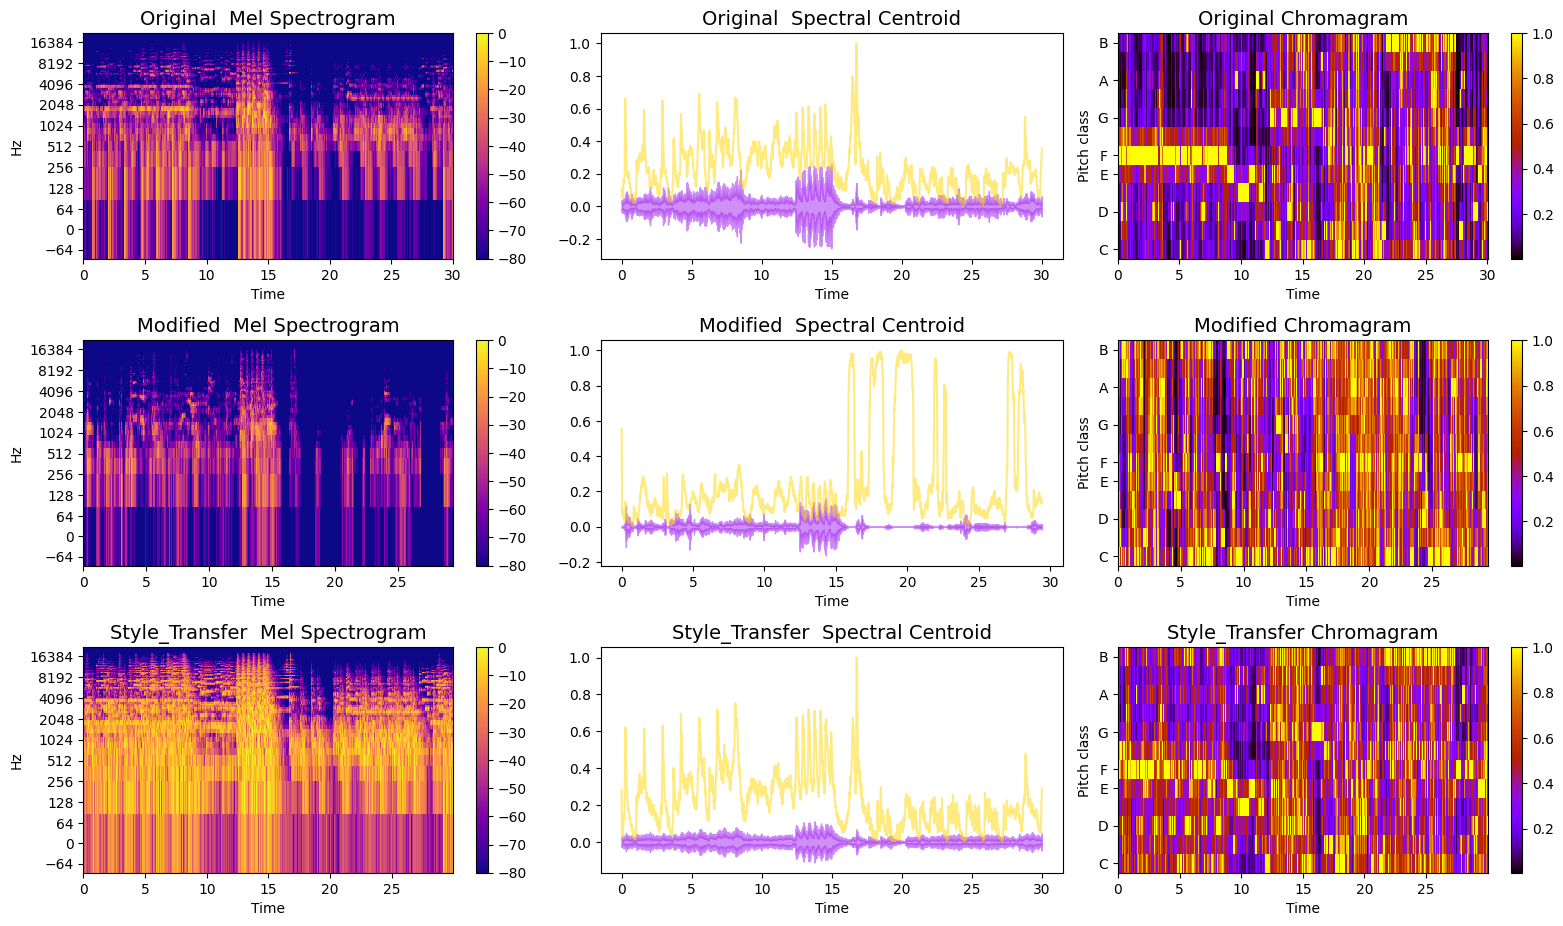

In [1]:
import os
import torch
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import sklearn.preprocessing
import wget
import IPython.display as ipd

#parameter settings
sample_rate = 44100 

#folder where pretrained models will be downloaded
pt_path = "rave_models" 
 #create the folder if it doesn't exist
if not os.path.exists(pt_path):
    os.mkdir(pt_path)

#pretrained_models to download in https://acids-ircam.github.io/rave_models_download 
pretrained_model = "vintage"
#check if the model file exists, if not, download it
if not os.path.exists(os.path.join(pt_path, f"{pretrained_model}.ts")):
    print(f"Downloading {pretrained_model}.ts...")
    wget.download(f"https://play.forum.ircam.fr/rave-vst-api/get_model/{pretrained_model}", f"{pt_path}/{pretrained_model}.ts")
else:
    print(f"{pretrained_model}.ts already downloaded.")

#load and process audio
def new_audio(input_file, output_file, pretrained_model, pt_path):
    model_file_path = os.path.join(pt_path, f"{pretrained_model}.ts")
    #load model
    model = torch.jit.load(model_file_path).eval()
    #disable gradients
    torch.set_grad_enabled(False)

    #load input audio data
    input_data = librosa.load(input_file, sr=sample_rate)[0]
    #convert audio to tensor and add batch and channel dimensions
    x = torch.from_numpy(input_data).reshape(1, 1, -1) 
    #encode audio into latent representation 
    z = model.encode(x)  
    #synthesize audio from latent representation
    y = model.decode(z).numpy()  
    #remove batch and channel dimensions
    y = y[:, 0, :].reshape(-1) 
    #trim to match input length --> for some reason the output is a bit longer than the input
    y = y[abs(len(input_data)- len(y)):]
    #save modified audio
    sf.write(output_file, y, sample_rate)

#visualize audio,ref:https://www.kaggle.com/code/andradaolteanu/work-w-audio-data-visualise-classify-recommend/notebook#Introduction
def visualize_audio(files, titles, sr=sample_rate):
    plt.figure(figsize=(16, 12)) 
    #loop through each file in list with index
    for i, file_path in enumerate(files):
        #load audio 
        y, sr = librosa.load(file_path, sr=sr)
        #trim leading and trailing silence from an audio signal
        y, _ = librosa.effects.trim(y)
        #compute Mel spectrogram 
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        #convert amplitude to decibel scale
        S_DB = librosa.amplitude_to_db(S, ref=np.max)
        #compute spectral centroid 
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        #create frames
        frames = range(len(spectral_centroids))
        #convert frames to time
        t = librosa.frames_to_time(frames, sr=sr)
        #normalize spectral centroids
        norm_spectral_centroids = sklearn.preprocessing.minmax_scale(spectral_centroids, axis=0)
        #compute chromagram
        hop_length = 512
        chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)

        #create subplot for Mel spectrogram
        plt.subplot(4, 3, 3*i+1)
        #display Mel spectrogram
        librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='plasma')
        plt.colorbar()
        plt.title(f"{titles[i]}  Mel Spectrogram", fontsize=14)
    
        #create subplot for Mel spectral centroids
        plt.subplot(4, 3, 3*i+2)
        librosa.display.waveshow(y, sr=sr, alpha=0.5,color='#A020F0')
        plt.plot(t, norm_spectral_centroids, alpha=0.5,color='#FFD700')
        plt.title(f"{titles[i]}  Spectral Centroid", fontsize=14)

        #create subplot for  chromagram
        plt.subplot(4, 3, 3*i+3)
        librosa.display.specshow(chromagram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='chroma', cmap='gnuplot')
        plt.colorbar()
        plt.title(f"{titles[i]} Chromagram", fontsize=14)

    plt.tight_layout()
    plt.show()

#load input audio
input_file = "generated/jazz.wav"  
new_audio_file = "generated/output_audio_2.wav"  
#output file path for modified audio
output_file = "generated/modified_audio.wav"  

#perform audio processing and visualization
new_audio(input_file, output_file, pretrained_model, pt_path)
visualize_audio(
    files=[input_file, output_file, new_audio_file],  
    titles=['Original', 'Modified', 'Style_Transfer']  )